<a href="https://colab.research.google.com/github/rafasacaan/dylan-gpt/blob/main/autoencoders_intermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders for ECG anomaly detection

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [360]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

import umap
import umap.plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Utilities

In [361]:
def get_clf_eval(
    y_test,
    pred=None,
    pred_proba=None
    ):
    # Run metrics
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('confusion matrix')
    print(confusion)

    # ROC-AUC print
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

### EDA

Load data from local source (`ecg.csv`)

In [48]:
dataframe = pd.read_csv('ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head().style.set_properties(
    **{
        'background-color': 'orange',
        'color': 'white',
        'border-color': 'white'
      }
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,0.071195,0.123925,0.103124,0.225228,0.128683,0.302483,0.257276,0.196352,0.179383,0.244729,0.341217,0.328204,0.406042,0.446605,0.424068,0.481512,0.477844,0.624083,0.574585,0.598013,0.564592,0.607979,0.620635,0.656253,0.684748,0.694273,0.665584,0.575796,0.638135,0.614917,0.569083,0.468576,0.442818,0.468274,0.432493,0.407958,0.418623,0.362531,0.410959,0.471666,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.000000
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,0.271695,0.259003,0.269202,0.127065,0.202073,0.255983,0.153115,0.210216,0.191082,0.190927,0.210510,0.207108,0.204888,0.200865,0.346920,0.348002,0.254537,0.331975,0.356690,0.349930,0.430380,0.467502,0.486063,0.403188,0.478956,0.397392,0.464120,0.451795,0.361361,0.379831,0.342785,0.399107,0.387508,0.255703,0.284034,0.284993,0.250108,0.173036,0.149423,0.141685,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.000000
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,0.109521,0.158078,0.291898,0.261294,0.188407,0.140651,0.263365,0.287207,0.314317,0.177942,0.138290,0.321069,0.458168,0.251916,0.261353,0.277488,0.298793,0.459075,0.419147,0.520509,0.537761,0.603211,0.475634,0.521693,0.735248,0.729541,0.718523,0.498433,0.545441,0.604827,0.521296,0.394381,0.405020,0.597563,0.531130,0.377651,0.467701,0.457569,0.341116,0.407913,0.459127,0.403937,0.298191,0.46110

In [49]:
dataframe.shape

(4998, 141)

Check target imbalance

In [50]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Abnormal']

# Read last column (target column)
values = dataframe[140].value_counts(normalize=True)

# Choose plot type
fig = go.Figure(
    data=[go.Pie(labels=labels, values=values, hole=.3)]
)
fig.update_traces(
    hoverinfo='label+percent', textinfo='percent', textfont_size=20,
    marker=dict(colors=colors, line=dict(color='white', width=0.1))
)
fig.update_layout(
    title_text="ECG dataset",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="grey",
    plot_bgcolor='grey',
    font_color="white",
)
fig.show()

Looks well balanced!

### Dataset split

In [51]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data,
    labels,
    test_size=0.2,
    random_state=21
)

In [52]:
train_data.shape

(3998, 140)

In [53]:
train_labels.shape

(3998,)

In [54]:
test_data.shape

(1000, 140)

In [55]:
test_labels.shape

(1000,)

### Preprocessing

In [56]:
min_val = np.min(train_data)
max_val = np.max(train_data)

# Normalize data (min/max)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Cast to float32
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

In [57]:
print(f'{min_val=}')
print(f'{max_val=}')

min_val=-6.2808752
max_val=7.4021031


**Train the autoencoder using only the normal rhythm labels** =1 on this dataset. Separates normal from abnormal rhythms.

In [59]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("n samples of train :",len(train_labels))
print("n samples of test :",len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

print("n samples of normal train :",len(normal_train_data))
print("n samples of normal test :",len(normal_test_data))

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

print("n samples of anomalous train :",len(anomalous_train_data))
print("n samples of anomalous test :",len(anomalous_test_data))

n samples of train : 3998
n samples of test : 1000
n samples of normal train : 2359
n samples of normal test : 560
n samples of anomalous train : 1639
n samples of anomalous test : 440


Plot a normal ECG

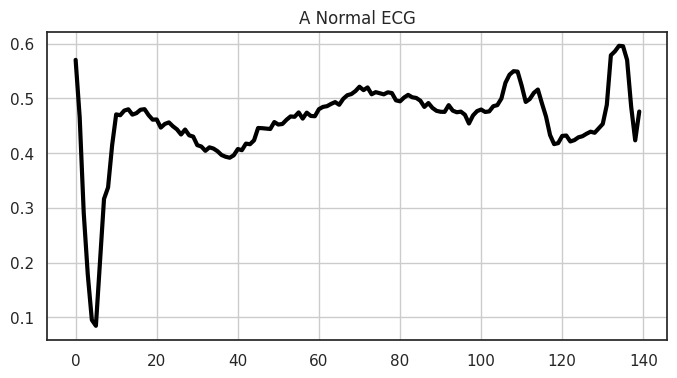

In [60]:
plt.figure(figsize=(8,4))
sns.set(font_scale=1)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), normal_train_data[0],color='black',linewidth=3.0)
plt.title("A Normal ECG");

Plot abnormal ECG

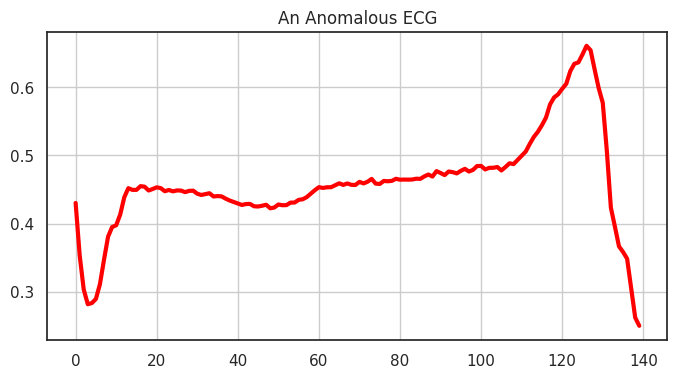

In [61]:
plt.figure(figsize=(8,4))
sns.set(font_scale=1)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0],color='red',linewidth=3.0)
plt.title("An Anomalous ECG")
plt.show();

### Modeling

In [62]:
class AnomalyDetectorLinear(nn.Module):
    def __init__(self):
        super(AnomalyDetectorLinear, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(140, 32), # N, 140 -> N, 32
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 140),
            nn.Sigmoid()  # ensure output is bounded between 0 and 1 (same as input)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [63]:
autoencoder = AnomalyDetectorLinear()

In [64]:
autoencoder

AnomalyDetectorLinear(
  (encoder): Sequential(
    (0): Linear(in_features=140, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=140, bias=True)
    (5): Sigmoid()
  )
)

### Training

Lets define the optimizer and loss criteria.

In [66]:
# Define optimizer and loss function
optimizer = optim.Adam(params=autoencoder.parameters())
criterion = nn.MSELoss()

Lets train on the normal ECGs, but test on the full test set.

In [67]:
# Create pytorch datasets
train_normal_dataset = TensorDataset(
    torch.Tensor(normal_train_data),
    torch.Tensor(normal_train_data)
  )

test_dataset = TensorDataset(
    torch.Tensor(test_data),
    torch.Tensor(test_data)
  )

# Create pytorch dataloaders
train_normal_loader = DataLoader(
    train_normal_dataset,
    batch_size=512,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False
)

In [71]:
N_EPOCHS = 20
train_losses = []
val_losses = []

# Training loop
for epoch in range(N_EPOCHS):
    running_loss = 0.0

    for inputs, targets in train_normal_loader:
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    epoch_loss = running_loss / len(train_normal_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluation on validation set
    autoencoder.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss = 0.0
        for val_inputs, val_targets in test_loader:  # Assuming val_loader is DataLoader for validation set
            val_outputs = autoencoder(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item() * val_inputs.size(0)

        # Compute average validation loss for the epoch
        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)

    autoencoder.train()  # Set model back to training mode

    print(f"Epoch [{epoch+1}/20], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch [1/20], Training Loss: 0.0078, Validation Loss: 0.0078
Epoch [2/20], Training Loss: 0.0073, Validation Loss: 0.0074
Epoch [3/20], Training Loss: 0.0069, Validation Loss: 0.0071
Epoch [4/20], Training Loss: 0.0065, Validation Loss: 0.0068
Epoch [5/20], Training Loss: 0.0061, Validation Loss: 0.0064
Epoch [6/20], Training Loss: 0.0057, Validation Loss: 0.0061
Epoch [7/20], Training Loss: 0.0053, Validation Loss: 0.0058
Epoch [8/20], Training Loss: 0.0048, Validation Loss: 0.0055
Epoch [9/20], Training Loss: 0.0044, Validation Loss: 0.0052
Epoch [10/20], Training Loss: 0.0040, Validation Loss: 0.0049
Epoch [11/20], Training Loss: 0.0035, Validation Loss: 0.0046
Epoch [12/20], Training Loss: 0.0031, Validation Loss: 0.0044
Epoch [13/20], Training Loss: 0.0026, Validation Loss: 0.0043
Epoch [14/20], Training Loss: 0.0023, Validation Loss: 0.0040
Epoch [15/20], Training Loss: 0.0020, Validation Loss: 0.0037
Epoch [16/20], Training Loss: 0.0017, Validation Loss: 0.0035
Epoch [17/20], Tr

In [78]:
len(train_losses), len(val_losses)

(20, 20)

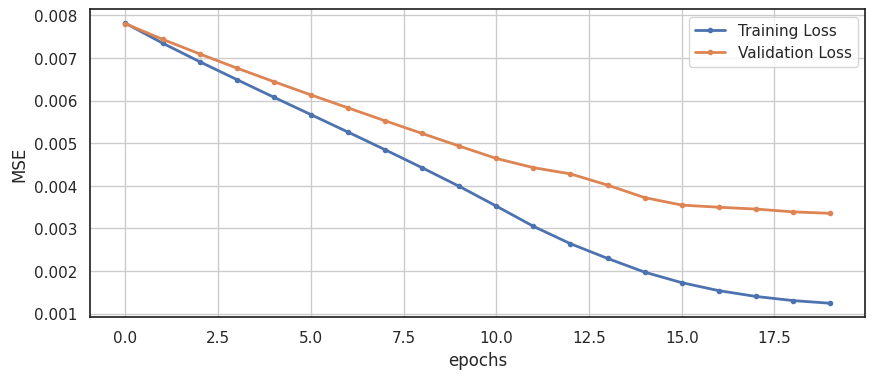

In [83]:
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
sns.set_style("white")
plt.plot(train_losses, label="Training Loss",linewidth=2.0, marker='.')
plt.plot(val_losses, label="Validation Loss",linewidth=2.0, marker='.')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.grid(True);
plt.legend();

**Threshold criteria:**

If the reconstruction error is greater than one standard deviation from the normal training example, classify the ECG as abnormal.

### Lets check the **normal signals** from the test set

In [89]:
normal_test_data

array([[0.48035768, 0.28877792, 0.19828546, ..., 0.45463306, 0.5246125 ,
        0.3713729 ],
       [0.45354807, 0.2557325 , 0.15979648, ..., 0.4801337 , 0.5284734 ,
        0.49527124],
       [0.4521779 , 0.25685105, 0.12592098, ..., 0.55448556, 0.5861353 ,
        0.4754273 ],
       ...,
       [0.48304972, 0.36122933, 0.27729514, ..., 0.32799056, 0.3158066 ,
        0.26930442],
       [0.4090865 , 0.27907097, 0.22604261, ..., 0.39099607, 0.45987615,
        0.42140076],
       [0.42648116, 0.17669384, 0.14546008, ..., 0.4733389 , 0.55036914,
        0.37805188]], dtype=float32)

In [91]:
normal_test_data.shape

(560, 140)

Encode normal test images

In [92]:
encoded_imgs = autoencoder.encoder(
    torch.from_numpy(normal_test_data) # transform to tensor
)

In [93]:
encoded_imgs.shape

torch.Size([560, 8])

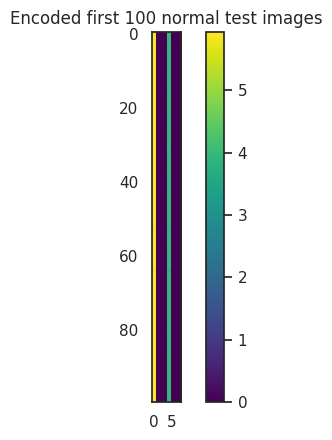

In [115]:
img = plt.imshow(
  encoded_imgs.detach().numpy()[:100,:],
  cmap='viridis'
)
plt.colorbar(img)
plt.title('Encoded first 100 normal test images');

Decode the images now

In [111]:
decoded_imgs = autoencoder.decoder(encoded_imgs).detach().numpy()

In [112]:
decoded_imgs.shape

(560, 140)

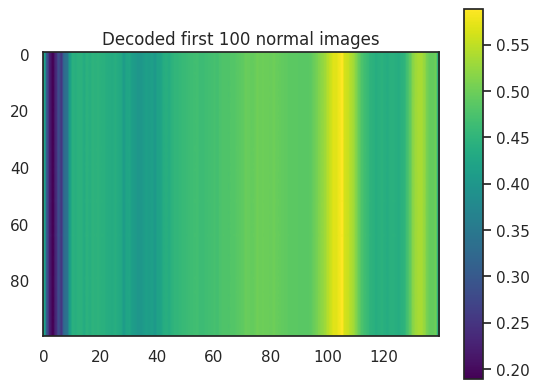

In [116]:
img = plt.imshow(
  decoded_imgs[:100,:],
  cmap='viridis'
)
plt.colorbar(img)
plt.title("Decoded first 100 normal images");

Lets plot the original and recosntructed ECG signals

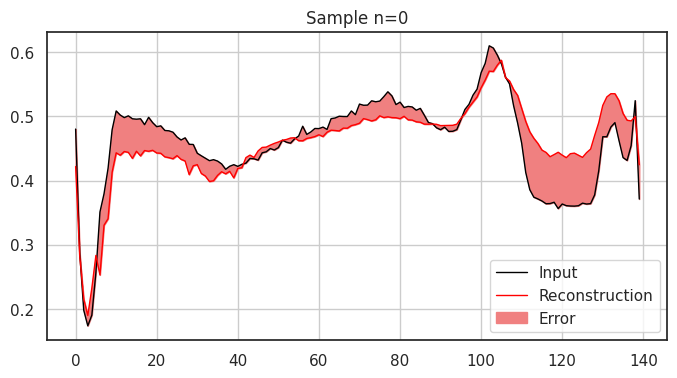

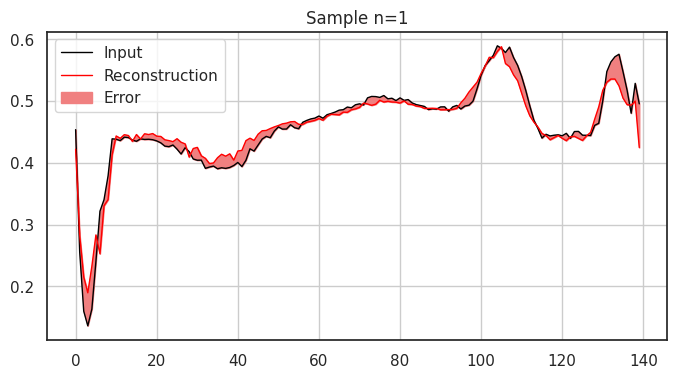

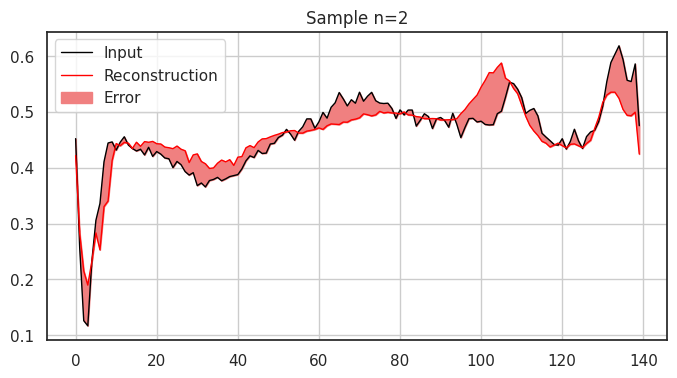

In [121]:
for i in range(0,3):
    plt.figure(figsize=(8,4))
    sns.set(font_scale=1)
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'black',linewidth=1)
    plt.plot(decoded_imgs[i], 'red',linewidth=1)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.grid(True)
    plt.title(f'Sample n={i}')
    plt.show();

Normal signals form test set

In [123]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs.detach().numpy())
encoded_imgs_normal['label'] = 1

In [124]:
encoded_imgs_normal

,0,1,2,3,4,5,6,7,label
0,5.900652,0.0,0.0,0.006071,3.938830,0.0,0.0,0.0,1
1,5.925798,0.0,0.0,0.007525,3.955845,0.0,0.0,0.0,1
2,5.927432,0.0,0.0,0.008917,3.952335,0.0,0.0,0.0,1
3,5.890815,0.0,0.0,0.002592,3.922075,0.0,0.0,0.0,1
4,5.914591,0.0,0.0,0.004775,3.950128,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
555,5.913369,0.0,0.0,0.006629,3.939801,0.0,0.0,0.0,1
556,5.921710,0.0,0.0,0.006299,3.953193,0.0,0.0,0.0,1
557,5.893859,0.0,0.0,0.008070,3.918530,0.0,0.0,0.0,1
558,5.918196,0.0,0.0,0.005334,3.955585,0.0,0.0,0.0,1


### Lets check **abnormal signals** from the test set

In [125]:
encoded_imgs = autoencoder.encoder(
    torch.from_numpy(anomalous_test_data) # transform to tensor
)

decoded_imgs = autoencoder.decoder(encoded_imgs).detach().numpy()

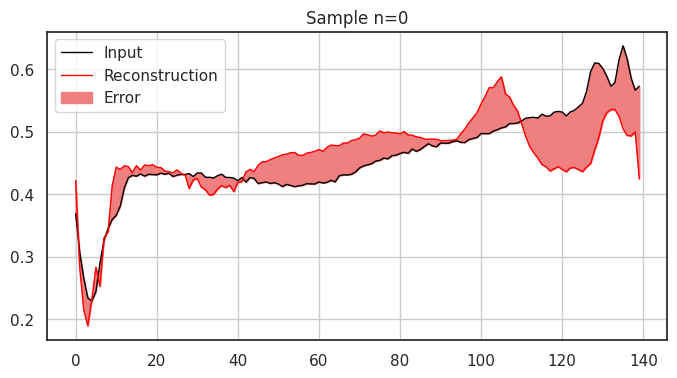

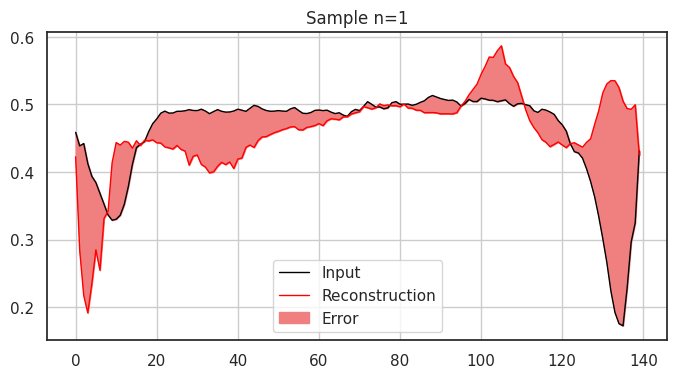

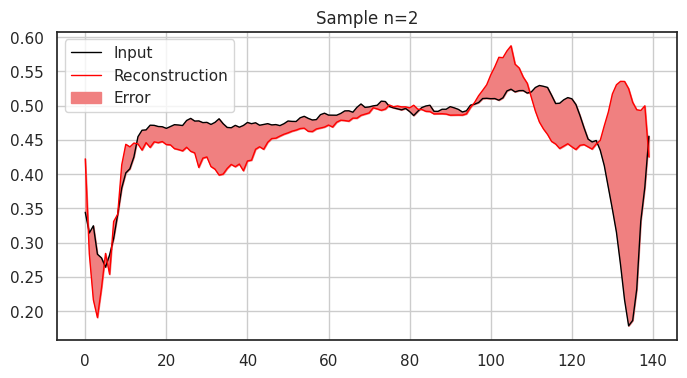

In [129]:
for i in range(0,3):
    plt.figure(figsize=(8,4))
    sns.set(font_scale=1)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'black',linewidth=1)
    plt.plot(decoded_imgs[i], 'red',linewidth=1)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.grid(True)
    plt.title(f'Sample n={i}')
    plt.show();

In [130]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs.detach().numpy())
encoded_imgs_abnormal['label'] = 0

In [131]:
encoded_imgs_abnormal

,0,1,2,3,4,5,6,7,label
0,5.930182,0.0,0.0,0.007528,3.951930,0.0,0.0,0.0,0
1,5.827940,0.0,0.0,0.000000,3.898548,0.0,0.0,0.0,0
2,5.854814,0.0,0.0,0.000000,3.918850,0.0,0.0,0.0,0
3,5.869296,0.0,0.0,0.000000,3.919211,0.0,0.0,0.0,0
4,5.867221,0.0,0.0,0.000000,3.927215,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
435,5.825356,0.0,0.0,0.000000,3.882628,0.0,0.0,0.0,0
436,5.856946,0.0,0.0,0.000000,3.920051,0.0,0.0,0.0,0
437,5.850064,0.0,0.0,0.000000,3.914228,0.0,0.0,0.0,0
438,5.820351,0.0,0.0,0.000000,3.894112,0.0,0.0,0.0,0


## Plot the latent space

Concat normal and abnormal ECGs from the test set, already encoded

In [132]:
all_encoded = pd.concat([encoded_imgs_normal, encoded_imgs_abnormal])

In [133]:
all_encoded

,0,1,2,3,4,5,6,7,label
0,5.900652,0.0,0.0,0.006071,3.938830,0.0,0.0,0.0,1
1,5.925798,0.0,0.0,0.007525,3.955845,0.0,0.0,0.0,1
2,5.927432,0.0,0.0,0.008917,3.952335,0.0,0.0,0.0,1
3,5.890815,0.0,0.0,0.002592,3.922075,0.0,0.0,0.0,1
4,5.914591,0.0,0.0,0.004775,3.950128,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
435,5.825356,0.0,0.0,0.000000,3.882628,0.0,0.0,0.0,0
436,5.856946,0.0,0.0,0.000000,3.920051,0.0,0.0,0.0,0
437,5.850064,0.0,0.0,0.000000,3.914228,0.0,0.0,0.0,0
438,5.820351,0.0,0.0,0.000000,3.894112,0.0,0.0,0.0,0


Plot latent space of 140 dimensions compressed into 8 dimension, and then in to 2 dimensions using UMAP algorithm.

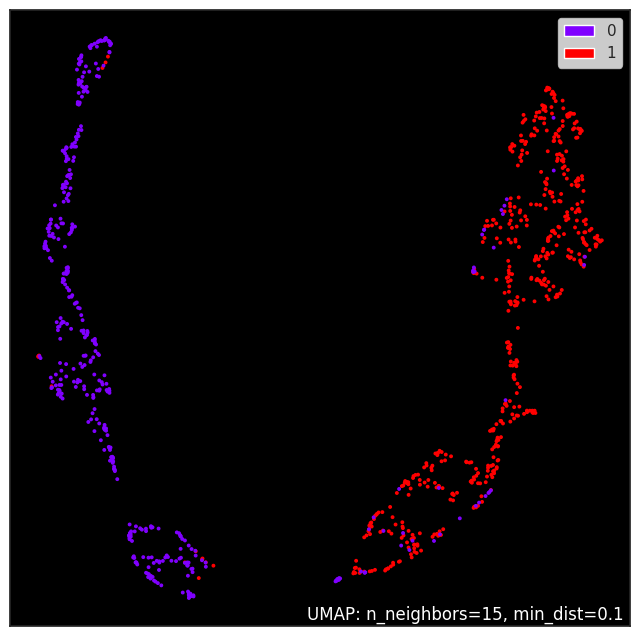

In [135]:
mapper = umap.UMAP().fit(all_encoded.iloc[:,:8])
umap.plot.points(mapper, labels=all_encoded.iloc[:,8], theme='fire');

## UMAP connectivity plot

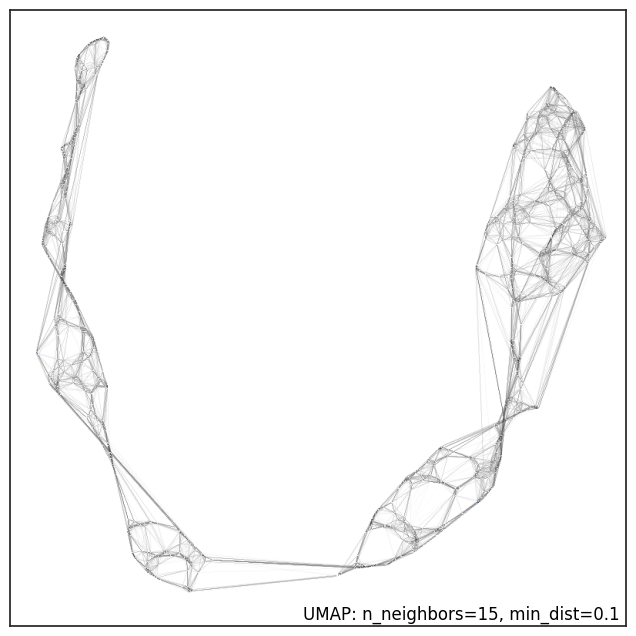

In [136]:
umap.plot.connectivity(mapper, show_points=True);

## Detecting embedding

Anomalies are detected by calculating whether the reconstruction loss is greater than a fixed threshold.

Therefore, we compute the mean error for normal examples in the training set, and then classify future examples as abnormal if the reconstruction error is greater than the standard deviation of the training set.

In [238]:
# Reconstruct normal train data
reconstructions_normal_train = autoencoder(
    torch.from_numpy(normal_train_data)
)

In [240]:
# Compute MAE
train_loss_normal_train = F.l1_loss(
    reconstructions_normal_train,
    torch.from_numpy(normal_train_data),
    reduction='mean'
)

In [241]:
train_loss_normal_train.detach().numpy()

array(0.02174181, dtype=float32)

In [245]:
abs_diff = torch.abs(
    reconstructions_normal_train - torch.from_numpy(normal_train_data),
)
normal_train_maes = torch.mean(abs_diff, dim=1)
normal_train_maes = normal_train_maes.detach().numpy()

normal_train_maes.shape, np.mean(normal_train_maes)

((2359,), 0.021741806)

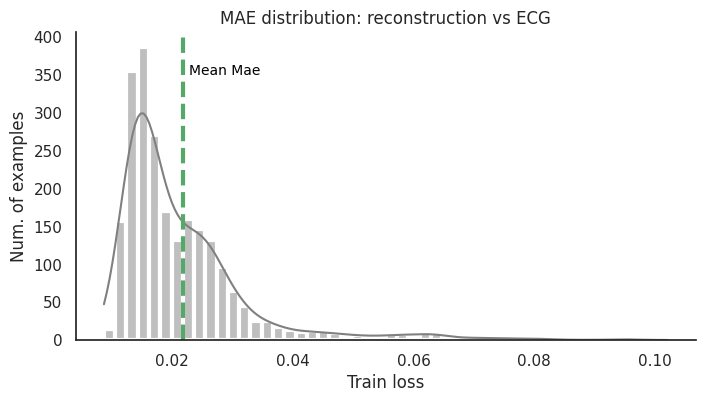

In [246]:
# Plot histogram of losses (MAEs)
plt.figure(figsize=(8,4))
sns.set(font_scale=1)
sns.set_style("white")

sns.histplot(
    normal_train_maes,
    bins=50,
    kde=True,
    color='grey',
    linewidth=3
)

# normal_train_maes
plt.axvline(x=np.mean(normal_train_maes), color='g', linestyle='--', linewidth=3)

plt.text(
    0.001 + np.mean(normal_train_maes), 350, "Mean Mae", horizontalalignment='left',
    size='small', color='black'
)

plt.xlabel("Train loss")
plt.ylabel("Num. of examples")
plt.title('MAE distribution: reconstruction vs ECG')
sns.despine()

Lets choose a threshold

In [247]:
normal_train_maes_mean = np.mean(normal_train_maes)
normal_train_maes_std = np.std(normal_train_maes)

normal_train_maes_mean, normal_train_maes_std

(0.021741806, 0.011584357)

In [248]:
threshold = normal_train_maes_mean + normal_train_maes_std
print("Threshold: ", threshold)

Threshold:  0.033326164


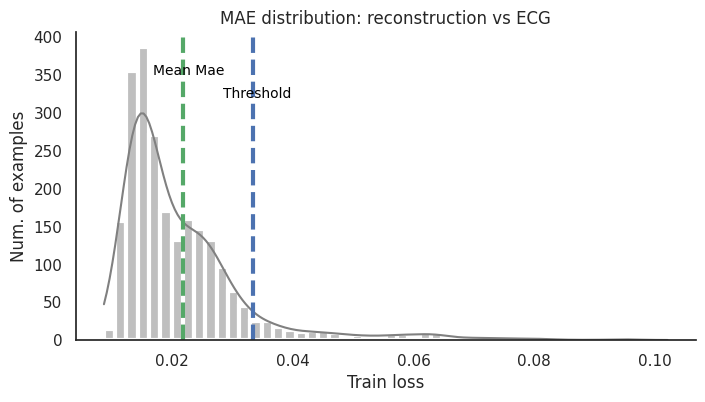

In [249]:
# Plot histogram of losses (MAEs)
plt.figure(figsize=(8,4))
sns.set(font_scale=1)
sns.set_style("white")

sns.histplot(
    normal_train_maes,
    bins=50,
    kde=True,
    color='grey',
    linewidth=3
)

# mean
plt.axvline(x=normal_train_maes_mean, color='g', linestyle='--', linewidth=3)

plt.text(
    - 0.005 + normal_train_maes_mean, 350, "Mean Mae", horizontalalignment='left',
    size='small', color='black'
)

# threshold
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(
    - 0.005 + threshold, 320, "Threshold", horizontalalignment='left',
    size='small', color='black'
)


plt.xlabel("Train loss")
plt.ylabel("Num. of examples")
plt.title('MAE distribution: reconstruction vs ECG')
sns.despine()

In [250]:
# Reconstruct anomalous test data
reconstructions_abnormal_test = autoencoder(
    torch.from_numpy(anomalous_test_data)
)

# Compute MAE
abnormal_test_loss = F.l1_loss(
    reconstructions_abnormal_test,
    torch.from_numpy(anomalous_test_data),
    reduction='mean'
)

abnormal_test_loss.detach().numpy()

array(0.04951723, dtype=float32)

In [252]:
abs_diff = torch.abs(
    reconstructions_abnormal_test - torch.from_numpy(anomalous_test_data),
)
maes = torch.mean(abs_diff, dim=1)
abnormal_test_maes = maes.detach().numpy()

abnormal_test_maes.shape, np.mean(abnormal_test_maes)

((440,), 0.04951723)

In [253]:
abnormal_test_maes_mean = np.mean(abnormal_test_maes)
abnormal_test_maes_std = np.std(abnormal_test_maes)

abnormal_test_maes_mean, abnormal_test_maes_std

(0.04951723, 0.008251596)

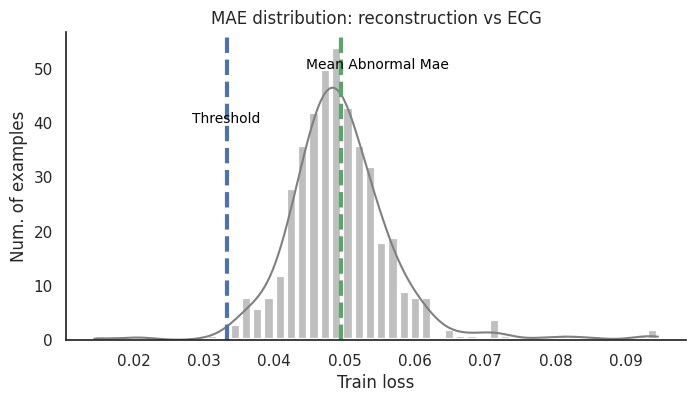

In [254]:
# Plot histogram of losses (MAEs)
plt.figure(figsize=(8,4))
sns.set(font_scale=1)
sns.set_style("white")

sns.histplot(
    abnormal_test_maes,
    bins=50,
    kde=True,
    color='grey',
    linewidth=3
)

# mean
plt.axvline(x=abnormal_test_maes_mean, color='g', linestyle='--', linewidth=3)

plt.text(
    - 0.005 + abnormal_test_maes_mean, 50, "Mean Abnormal Mae", horizontalalignment='left',
    size='small', color='black'
)

# threshold
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(
    - 0.005 + threshold, 40, "Threshold", horizontalalignment='left',
    size='small', color='black'
)


plt.xlabel("Train loss")
plt.ylabel("Num. of examples")
plt.title('MAE distribution: reconstruction vs ECG')
sns.despine()

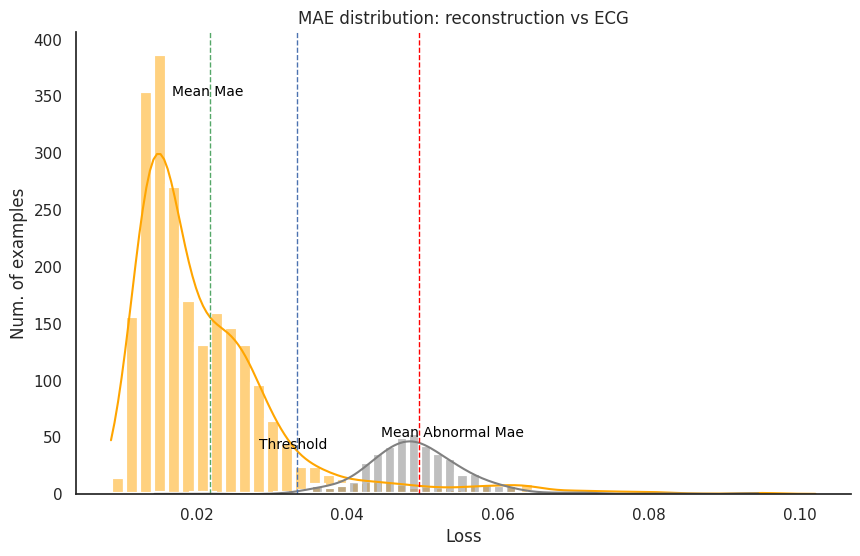

In [261]:
# Plot histogram of losses (MAEs)
plt.figure(figsize=(10,6))
sns.set(font_scale=1)
sns.set_style("white")


# Normal
sns.histplot(
    normal_train_maes,
    bins=50,
    kde=True,
    color='orange',
    linewidth=3
)
# Normal mean
plt.axvline(x=normal_train_maes_mean, color='g', linestyle='--', linewidth=1)
plt.text(
    - 0.005 + normal_train_maes_mean, 350, "Mean Mae", horizontalalignment='left',
    size='small', color='black'
)

# Abnormal
sns.histplot(
    abnormal_test_maes,
    bins=50,
    kde=True,
    color='grey',
    linewidth=3
)

# Abnormal mean
plt.axvline(x=abnormal_test_maes_mean, color='red', linestyle='--', linewidth=1)

plt.text(
    - 0.005 + abnormal_test_maes_mean, 50, "Mean Abnormal Mae", horizontalalignment='left',
    size='small', color='black'
)

# Threshold
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=1)
plt.text(
    - 0.005 + threshold, 40, "Threshold", horizontalalignment='left',
    size='small', color='black'
)


plt.xlabel("Loss")
plt.ylabel("Num. of examples")
plt.title('MAE distribution: reconstruction vs ECG')
sns.despine()

## Predicting

Utility functions

In [324]:
def predict(model, data, threshold):
    model.eval()
    data_tensor = torch.from_numpy(data)
    with torch.no_grad():
        reconstructions = model(data_tensor)

    abs_diff = torch.abs(
        reconstructions - data_tensor
    )
    loss = torch.mean(abs_diff, dim=1)
    predictions = loss < threshold  # This will return a tensor of booleans
    return predictions.detach().numpy()

def print_stats(preds, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

Predict

In [362]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.947
Precision = 0.9922330097087378
Recall = 0.9125


Report metrics

In [363]:
confusion_matrix = get_clf_eval(test_labels, preds, preds)

confusion matrix
[[436   4]
 [ 49 511]]
accuracy: 0.9470, precision: 0.9922, recall: 0.9125,    F1: 0.9507, AUC:0.9517


<Axes: >

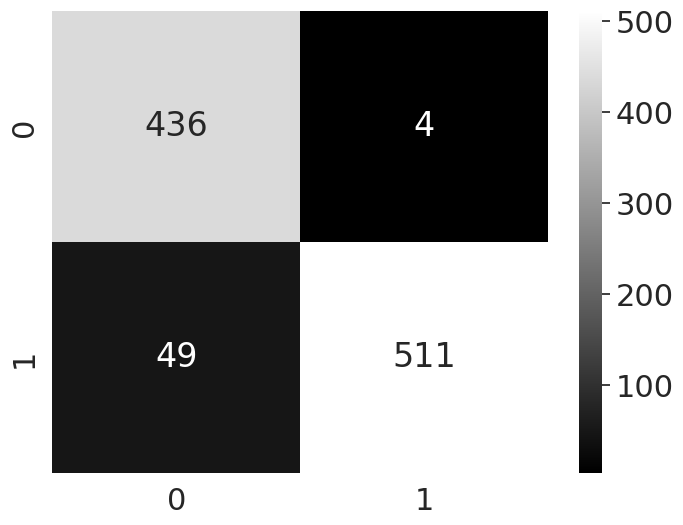

In [364]:
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')